In [1]:
import numpy as np
import tensorflow as tf
# TensorFlow ≥2.0 is required
assert tf.__version__ >= "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

### Carregando o conjunto de dados fashion MNIST. 

O Keras tem várias funções para carregar conjuntos de dados populares em `keras.datasets`. O conjunto de dados já está dividido para você entre um conjunto de treinamento e um conjunto de teste.

In [3]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

Vamos dividir o conjunto de treinamento em um conjunto de validação e um conjunto de treinamento (menor). Também **escalonamos** as magnitudes dos pixels para o intervalo de 0-1 e as convertemos em floats, dividindo por 255.

In [4]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Plotando algumas imagens do banco de dados.

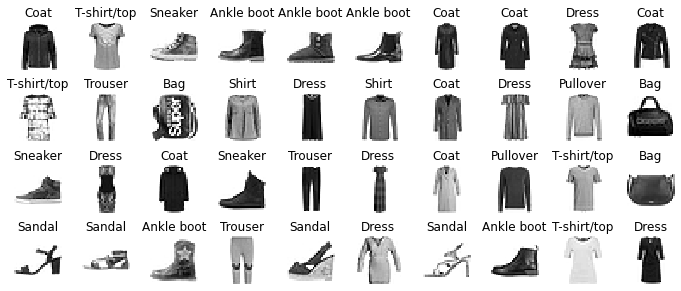

In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

### Criando um modelo sequencial

O modelos abaixo é o de um classificador MLP com duas camadas ocultas. Na sequência, descrevemos cada uma das linhas de código da célula abaixo.

+ A primeira linha cria um modelo Sequencial.
+ A primeira cadamda é uma camada `Flatten` cuja função é simplesmente converter cada imagem de entrada em uma array 1D. Esta camada não possui parâmetros, é apenas faz um pré-processamento simples de conversão.
    + Por ser a primeira camada do modelo, devemos especificar o parâmetro `input_shape`. Ele não inclui o tamanho do mini-batch, apenas as dimensões dos exemplos de entrada.
+ Em seguida, adicionamos uma camada oculta densa (i.e., classe `Dense`) com 300 neurônios. Ele usará a função de ativação **ReLU**.
+ Em seguida, adicionamos uma segunda camada oculta densa com 100 neurônios, também usando a função de ativação **ReLU**.
+ Por fim, adicionamos uma camada de saída densa com 10 neurônios (um para cada classe), usando o função de ativação **softmax**.

**IMPORTANTE**

+ Outras funções de ativação estão disponíveis no pacote `keras.activations`. Veja a lista completa em https://keras.io/activations/.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

### Resumo do modelo

O método `summary()` da classe `Sequential` exibe todas as camadas do modelo, incluindo o nome de cada camada (que é gerado automaticamente, a menos que você o defina ao criar a camada), seu formato de saída (`None` significa que o tamanho do mini-batch pode ser qualquer um) e seu número de parâmetros. O resumo termina imprimindo o número total de parâmetros, incluindo treináveis e não treináveis.

In [ ]:
model.summary()

**IMPORTANTE**

+ Observem que as camadas densas geralmente têm muitos parâmetros. Por exemplo, a primeira camada oculta tem 784 x 300 pesos, mais 300 termos de bias, o que soma 235.500 parâmetros.

+ Isso dá ao modelo bastante flexibilidade para ajustar os dados de treinamento, mas também significa que o modelo corre o risco de **overfitting**, especialmente quando não temos muitos dados de treinamento.

+ As camadas densas têm seus pesos inicializados aleatoriamente e os termos de bias são inicializados com zeros. 
    + Se quisermos usar um método de inicialização diferente, podemos definir o parâmetro `kernel_initializer` (kernel é outro nome para a matriz de pesos de conexão) ou `bias_initializer` ao criar a camada.
    + Os vários métodos de incialização estão listados em: https://keras.io/api/layers/initializers/

### Compilando o modelo

+ Depois que um modelo é criado, devemos chamar seu método `compile()` para especificar a **função de custo** e o **otimizador** que devem ser usados. 

+ Opcionalmente, também podemos especificar uma lista de métricas extras para calcular durante o treinamento e a valiação do modelo.

+ Listas com outras funções de custo, otimizadores e métricas podem ser encontaradas em

    + https://keras.io/losses/,

    + https://keras.io/optimizers/ 

    + https://keras.io/metrics/.

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

**IMPORTANTE**

+ Nós usamos a função de custo `sparse_categorical_crossentropy` porque temos rótulos esparsos (ou seja, para cada exemplo há apenas um índice de classe, de 0 a 9 neste caso).
+ Em relação ao otimizador, `sgd` significa simplesmente que treinaremos o modelo usando o gradiente descendente estocástico.
+ Como este é o modelo de um classificador, é útil medir sua acurácia (`accuracy`) durante seu treinamento e valiação.

### Treinando e avaliando o modelo

+ Para treinar o modelo, usamos o método `fit()`.
+ Passamos para ele os atributos de entrada (X_train) e os rótulos (y_train), bem como o número de épocas para treinar. 
+ Também passamos um conjunto de validação (opcional) que é usado para medir o cutso e as métricas extras neste conjunto no final de cada época.
    + Se o desempenho no conjunto de treinamento é muito melhor do que no conjunto de validação, o modelo provavelmente está sobreajustando.

In [ ]:
history = model.fit(X_train, y_train, epochs=50,
                    validation_data=(X_valid, y_valid))

**IMPORTANTE**

+ A cada época durante o treinamento, o modelo exibe o número de exemplos processados até o momento (junto com uma barra de progresso), o tempo médio de treinamento por exemplo, a perda e a acurácia (ou qualquer outra métrica extra solicitada), tanto no conjunto de treinamento quanto no conjunto de validação. 

+ Podemos ver que a perda de treinamento diminuiu, o que é um bom sinal, e a acurácia da validação atingiu 87.28% após 50 épocas, não muito longe da acurácia de treinamento, então não parece não estar correndo **sobreajuste**.

+ Em vez de passar um conjunto de validação usando o parâmetro `validation_data`, podemos definir o parâmetro `validation_split` com a proporção do conjunto de treinamento que desejamos que se seja usado para validação (por exemplo, 0.1).

### Avaliando o modelo

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

https://github.com/ageron/handson-ml2/blob/master/10_neural_nets_with_keras.ipynb